In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import optuna

C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('dailydataprice.csv', delimiter=",", encoding='latin-1', usecols=['Date', 'Price'])
df.head()

,Date,Price
0,4-Jan-00,84.37
1,5-Jan-00,85.54
2,6-Jan-00,84.77
3,7-Jan-00,82.64
4,10-Jan-00,84.69


In [4]:

dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07',  'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
for key, value in dict.items():
  df['Date'] = df['Date'].str.replace(key, value)

In [5]:
print(df.dtypes)

Date      object
Price    float64
dtype: object


In [6]:
df.columns =['Date', 'Price']
df.head()

,Date,Price
0,4-01-00,84.37
1,5-01-00,85.54
2,6-01-00,84.77
3,7-01-00,82.64
4,10-01-00,84.69


In [7]:
grouped_df = df.groupby('Date').Price.sum()
grouped_df

Date
1-02-00     78.48
1-02-01     49.11
1-02-02     42.64
1-02-05     82.34
1-02-06    101.52
            ...  
9-12-14    154.39
9-12-15    117.14
9-12-16    129.64
9-12-19    117.10
9-12-20    110.35
Name: Price, Length: 5379, dtype: float64

In [8]:
df = pd.DataFrame(grouped_df)
df = df.reset_index() # đoạn này có fix

In [9]:
print(df.dtypes)
print(df)

Date      object
Price    float64
dtype: object
         Date   Price
0     1-02-00   78.48
1     1-02-01   49.11
2     1-02-02   42.64
3     1-02-05   82.34
4     1-02-06  101.52
...       ...     ...
5374  9-12-14  154.39
5375  9-12-15  117.14
5376  9-12-16  129.64
5377  9-12-19  117.10
5378  9-12-20  110.35

[5379 rows x 2 columns]


In [9]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
print(df.dtypes)


C:\Users\Vũ Hoàng Tùng\AppData\Local\Temp\ipykernel_24764\439356622.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


Date     datetime64[ns]
Price           float64
dtype: object


In [10]:
def normalized(data, columns, method="minmax"):

    df_normalized = data.copy()

    if method == "minmax":
        scaler = MinMaxScaler()
    elif method == "standard":
        scaler = StandardScaler()
    else:
        raise ValueError("Method must be 'minmax' or 'standard'")

    valid_columns = [col for col in columns if col in df_normalized.columns]
    if not valid_columns:
        print("No valid columns found for normalization.")
        return df_normalized

    df_normalized[valid_columns] = scaler.fit_transform(df_normalized[valid_columns])

    return df_normalized

In [11]:
def showdata(data, start=0, end=None, normalize=True, method="minmax"):

    if end is None:
        end = len(data)  

    sliced_data = data.iloc[start:end].copy()

    col = [
        "Year" 
        , "Month"
        , "Day"
        , "DayOfWeek"
        , "Lag365"
        , "MeanWeek"
        , "MeanMonth"
        , "EMA_7"
        , "EMA_30"
        , "Price"]
    col = [c for c in col if c in sliced_data.columns]

    if not col:
        print("No matching columns found in the dataset.")
        return

    if normalize:
        sliced_data = normalized(sliced_data, col, method)

    plt.figure(figsize=(12, 6))
    for column in col:
        plt.plot(sliced_data['Date'], sliced_data[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Normalized Value' if normalize else 'Value')
    plt.title(f'Data Trend from {start} to {end} {"(Normalized)" if normalize else ""}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()


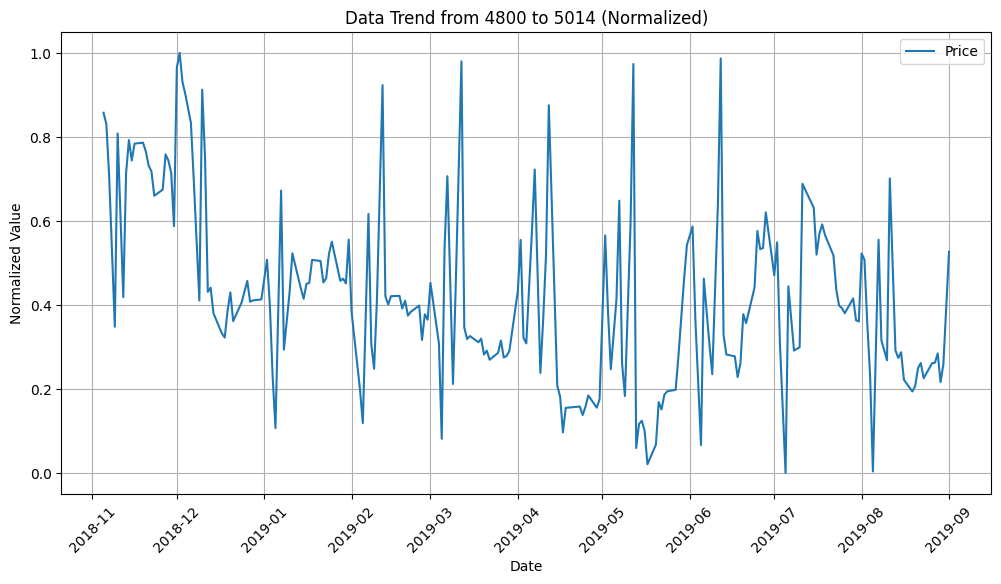

In [13]:
showdata(df,4800,5014)

Feature Extraction

In [12]:

df["Date"] = pd.to_datetime(df["Date"])

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.weekday


df["Lag365"] = df["Price"].shift(365)

df["MeanWeek"] = df["Price"].rolling(window=7).mean().shift(1)  
df["MeanMonth"] = df["Price"].rolling(window=30).mean().shift(1) 
df["EMA_7"] = df["Price"].ewm(span=7, adjust=False).mean()
df["EMA_30"] = df["Price"].ewm(span=30, adjust=False).mean()

df.dropna(inplace=True)

col = [
 #       "Year" 
 #       , "Month"
 #       , "Day"
  #     , "DayOfWeek"
   #     "Lag365",
         "MeanWeek"
        , "MeanMonth"
        , "EMA_7"
        , "EMA_30"]

X = df[col]
y = df["Price"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)  # No shuffle for time series

print(df)

           Date   Price  Year  Month  Day  DayOfWeek  Lag365    MeanWeek  \
365  2020-11-02   99.25  2020     11    2          0   78.48  135.168571   
366  2002-11-03   50.70  2002     11    3          6   49.11  131.725714   
367  2003-11-03   49.80  2003     11    3          0   42.64  108.724286   
368  2004-11-03   61.24  2004     11    3          2   82.34   97.092857   
369  2005-11-03  107.36  2005     11    3          3  101.52   87.765714   
...         ...     ...   ...    ...  ...        ...     ...         ...   
5374 2014-09-12  154.39  2014      9   12          4   49.14  122.314286   
5375 2015-09-12  117.14  2015      9   12          5   43.32  133.412857   
5376 2016-09-12  129.64  2016      9   12          0   75.51  138.160000   
5377 2019-09-12  117.10  2019      9   12          3   83.00  142.104286   
5378 2020-09-12  110.35  2020      9   12          5  106.97  141.034286   

       MeanMonth       EMA_7      EMA_30  
365   111.083000  115.319595  114.178955  
3

C:\Users\Vũ Hoàng Tùng\AppData\Local\Temp\ipykernel_37732\879480045.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [71]:
# rf = RandomForestRegressor(max_depth = 30, max_features= 'sqrt', min_samples_leaf =2, min_samples_split = 5, n_estimators = 100)
rf = RandomForestRegressor()
gb = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=10,
    min_samples_split=20,
    n_estimators=100,
    subsample=0.9
)

xgb = XGBRegressor(
    learning_rate=0.0696886981928362,
    n_estimators=395,
    max_depth=4,
    subsample=0.752267094377165,
    colsample_bytree=0.9265550138288761,
    gamma=5.222152554368784,
    reg_alpha=0.24931830144036302,
    reg_lambda=0.03556395419506893,
    min_child_weight=3,
    booster='dart'
)


In [79]:
meta_learner = LassoCV(cv=5)

stacking_model = StackingRegressor(estimators=[("rf",rf) ,("gb", gb)], final_estimator=meta_learner, cv= 5,passthrough=True)

stacking_model.fit(X_train, y_train)



C:\Users\Vũ Hoàng Tùng\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e+03, tolerance: 2.633e+02
  model = cd_fast.enet_coordinate_descent(


StackingRegressor(cv=5,
                  estimators=[('rf', RandomForestRegressor()),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         max_features='sqrt',
                                                         min_samples_leaf=10,
                                                         min_samples_split=20,
                                                         subsample=0.9))],
                  final_estimator=LassoCV(cv=5), passthrough=True)

In [80]:
meta_model = stacking_model.final_estimator_
weights = meta_model.coef_
print(meta_model)
print("Meta-learner model weights:")

model_names = list(stacking_model.named_estimators_.keys()) 

#model_names = ["RandomForest", "GradientBoosting", "XGBoost"]

for name, weight in zip(model_names, weights):
    print(f"Model: {name}, Weight: {weight:.4f}")


LassoCV(cv=5)
Meta-learner model weights:
Model: rf, Weight: 0.0262
Model: gb, Weight: 0.0000


In [82]:
y_pred = stacking_model.predict(X_test)

linear = RidgeCV(cv = 5)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

stack_mse= (mean_squared_error(y_test, y_pred))
stack_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
stack_r2 = r2_score(y_test, y_pred)
stack_acc = 100 - np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Squared Error: {stack_mse:.4f}")
print(f"R² Score: {stack_r2:.4f}")
print(f"Regression Accuracy: {stack_acc:.2f}%")

Mean Squared Error: 5.4252
R² Score: 0.8995
Regression Accuracy: 98.41%


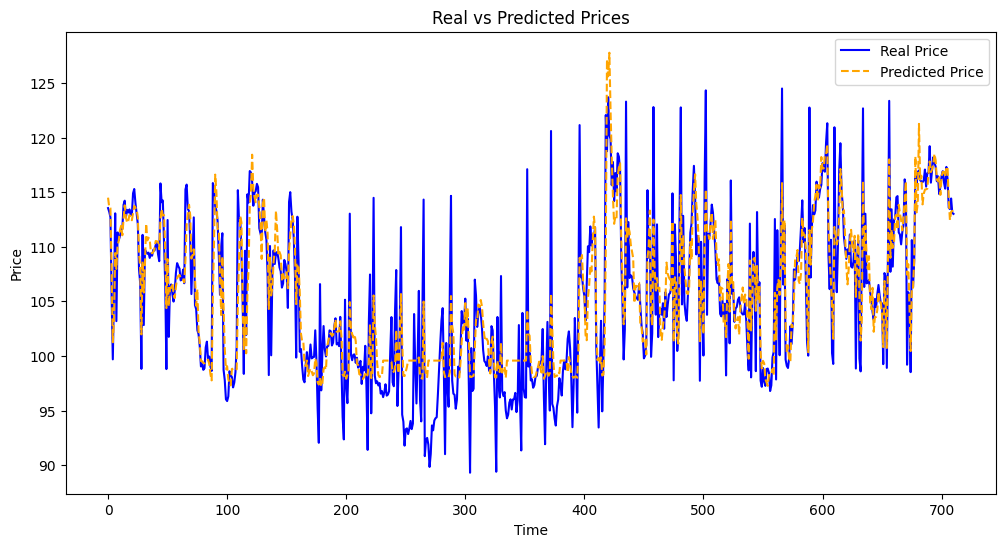

In [ ]:
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    
    y_test_sorted = y_test.reset_index(drop=True)
    y_pred_sorted = y_pred.flatten()  
    
    plt.plot(y_test_sorted, label="Real Price", color="blue")
    plt.plot(y_pred_sorted, label="Predicted Price", color="orange", linestyle="dashed")

    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("Real vs Predicted Prices")
    plt.legend()
    plt.show()

plot_predictions(y_test, y_pred)


Evaluate

Compare to base model

In [72]:
gb.fit(X_train, y_train)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)

# Compute R² Scores
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

rf_accuracy = 100 - rf_mape

print(f"Mean Squared Error of RFR: {rf_mse:.4f}")
print(f"R² Score of RFR: {rf_r2:.4f}")
print(f"Regression Accuracy of RFR: {rf_accuracy:.2f}%")

gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

gb_mape = np.mean(np.abs((y_test - gb_pred) / y_test)) * 100

gb_accuracy = 100 - gb_mape

print(f"Mean Squared Error of GBR: {gb_mse:.4f}")
print(f"R² Score of GBR: {gb_r2:.4f}")
print(f"Regression Accuracy of GBR: {gb_accuracy:.2f}%")

Mean Squared Error of RFR: 10.8337
R² Score of RFR: 0.7993
Regression Accuracy of RFR: 97.71%
Mean Squared Error of GBR: 20.2255
R² Score of GBR: 0.6253
Regression Accuracy of GBR: 96.72%


In [54]:
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

# Compute R² Scores
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

xgb_mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100

xgb_accuracy = 100 - xgb_mape

print(f"Mean Squared Error of XGBR: {xgb_mse:.4f}")
print(f"R² Score of XGBR: {xgb_r2:.4f}")
print(f"Regression Accuracy of XGBR: {xgb_accuracy:.2f}%")

Mean Squared Error of XGBR: 11.3532
R² Score of XGBR: 0.8772
Regression Accuracy of XGBR: 97.72%


In [24]:
def weighted_ensemble_predict(X, gb_model, xgb_model, weight_gb=0.5, weight_xgb=0.5):
    gb_pred = gb_model.predict(X)
    xgb_pred = xgb_model.predict(X)
    return (weight_gb * gb_pred) + (weight_xgb * xgb_pred)

gb.fit(X_train, y_train)
xgb.fit(X_train, y_train)

y_pred1 = weighted_ensemble_predict(X_test, gb, xgb, weight_gb=0.1, weight_xgb=0.9)


In [35]:
mse1 =(mean_squared_error(y_test, y_pred1))
rmse1 =np.sqrt(mean_squared_error(y_test, y_pred1))
r2_1 =(r2_score(y_test, y_pred1))

mape1 = np.mean(np.abs((y_test - y_pred1) / y_test)) * 100

accuracy1 = ( 100 - mape1)
print(f"Mean Squared Error: {mse1:.4f}")
print(f"R² Score: {r2_1:.4f}")
print(f"Regression Accuracy: {accuracy1:.2f}%")

ValueError: Found input variables with inconsistent numbers of samples: [930, 1003]

In [ ]:
mse = []
rmse = []
r2 = []
accuracy = []

mse.append(stack_mse)
rmse.append(stack_rmse)
r2.append(stack_r2)

accuracy.append( stack_acc)

# --- Random Forest (RF) ---
mse.append(rf_mse)
rmse.append(np.sqrt(rf_mse))
r2.append(rf_r2)
accuracy.append(rf_accuracy)

# --- Gradient Boosting (GB) ---
mse.append(gb_mse)
rmse.append(np.sqrt(gb_mse))
r2.append(gb_r2)
accuracy.append(gb_accuracy)

# --- XGBoost (XGB) ---

mse.append(xgb_mse)
rmse.append(np.sqrt(xgb_mse))
r2.append(xgb_r2)
accuracy.append(xgb_accuracy)

Mean Squared Error: 24.5191
R² Score: 0.7798
Regression Accuracy: 96.88%


In [34]:
models = ["Stack","RFR", "GBR", "XGBR"]
results_df = pd.DataFrame({
    "Model": models,
    "MSE": mse,
    "RMSE": rmse,
    "R² Score": r2,
    "Accuracy (%)": accuracy
})

print(results_df)


NameError: name 'mse' is not defined

In [ ]:
def analyze(model):
    feature_importance = model.feature_importances_

    # Plot importance
    plt.barh(X.columns, feature_importance)
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance")
    plt.show()
analyze(rf)

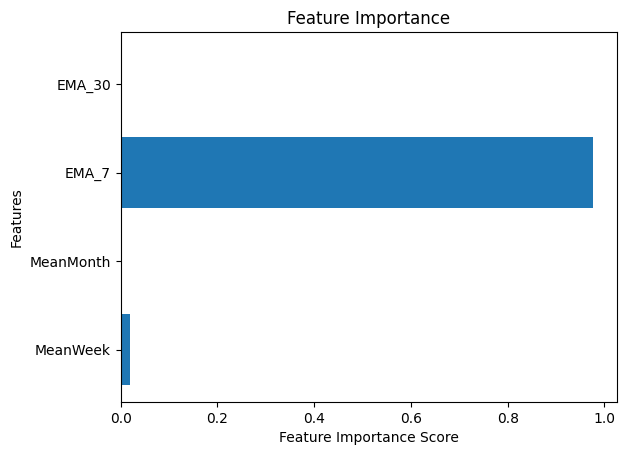

In [45]:
print(np.mean(y_pred - y_test))  # For Stacking Model
print(np.mean(rf_pred - y_test))  # For Random Forest


-6.398628541501448
-0.12350021505375343


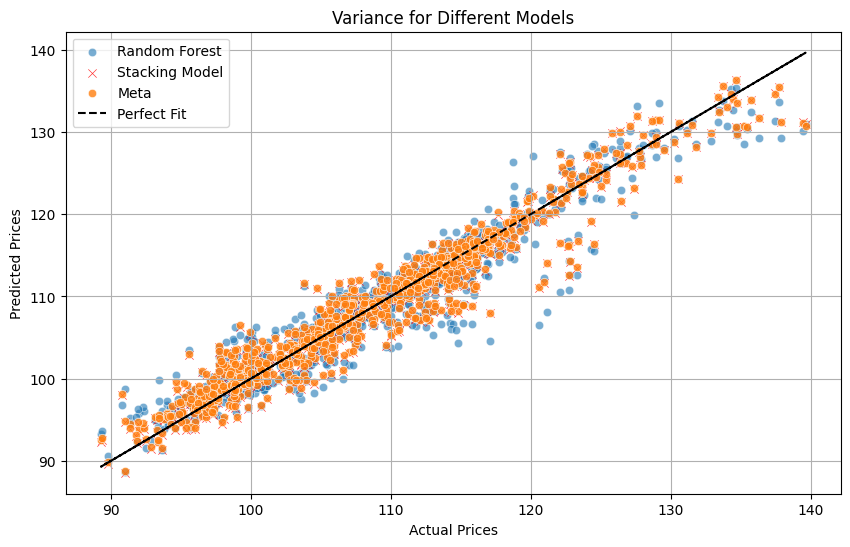

In [61]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=rf_pred, label="Random Forest", alpha=0.6)
#sns.scatterplot(x=y_test, y=gb_pred, label="Gradient Boosting", alpha=0.6)
#sns.scatterplot(x=y_test, y=xgb_pred, label="XGBoost", alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred, label="Stacking Model", alpha=0.8, marker="x", color="red")
sns.scatterplot(x=y_test, y=meta_pred, label="Meta", alpha=0.8)

plt.plot(y_test, y_test, color="black", linestyle="dashed", label="Perfect Fit")

# Labels & Legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Variance for Different Models")
plt.legend()
plt.grid(True)

plt.show()
